# NSBI diagnostics

In the previous chapter, we've trained CARL models that approximate the density ratio between two hypotheses of an event:

$$
 \hat{r}(x ; H_1, H_2) \sim r ( x ; H_1, H_2) \equiv \frac{p(x | H_1)}{p(x | H_2)}
$$

The validity of our NSBI results, of course, depends on close this approixmation, $~$, holds. We will perform two diagnostics to gauge how well our estimates are performing.

In [17]:
import numpy as np
import pandas as pd
import matplotlib, matplotlib.pyplot as plt
import vector
import hist

import torch
torch.set_float32_matmul_precision('medium')
from torch.utils.data import TensorDataset, DataLoader
import lightning as L

from physics.analysis import zz4l, zz2l2v
from datasets.balanced import BalancedDataset
from nsbi import carl

## 0. Load the training/validation data, scaler, and model checkpoint

First, we'll load everything we need. Note that if you set the same seed for the two models come into play, you only need to load denominator hypothesis datasets once; otherwise you will need the denominator datasets corresponding to each model separately.

In [10]:
run_dir = 'run/h4l'

(events_sig_train, events_sig_val), (events_bkg_train, events_bkg_val) = carl.utils.load_data(run_dir, 'sig_over_bkg')
(events_sbi_train, events_sbi_val), _ = carl.utils.load_data(run_dir, 'sig_over_bkg')  # same seed!

scaler_sig_over_bkg, model_sig_over_bkg = carl.utils.load_results(run_dir, 'sig_over_bkg')
scaler_sbi_over_bkg, model_sbi_over_bkg = carl.utils.load_results(run_dir, 'sbi_over_bkg')

features_4l = ['l1_pt', 'l1_eta', 'l1_phi', 'l1_energy', 'l2_pt', 'l2_eta', 'l2_phi', 'l2_energy', 'l3_pt', 'l3_eta', 'l3_phi', 'l3_energy', 'l4_pt', 'l4_eta', 'l4_phi', 'l4_energy']


## 1. Reweighting

An intuitive expectation of a DRE is that it should provide a correspondingly accurate reweighting of an event between hypotheses:

$$
 \hat{p}(x | H_1) = p(x| H_2) \times \hat{r}(x ; H_1, H_2) \Rightarrow \hat{w}_{H_2 \to H_1}(x) \sim w_{H_2}(x) \times r( x ; H_1, H_2) / N
$$

where $N$ is an arbitrary normalization factor (remember: we are performing a *density* ratio estimate!). In order to perform this check for one estimate, you must:

1. Scale the features of the denominator hypothesis events using the scaler from training.
2. Run the model over the scaled features.
3. Perform the likelihood trick over the output.

In [ ]:
# IMPLEMENT ME
events_num_train, events_train_denom = events_sig_train, events_sig_val 
scaler = scaler_sig_over_bkg
model = model_sig_over_bkg
events_denom_train, events_denom_val = events_bkg_train, events_bkg_val

X_denom_train, X_denom_val = scaler.transform(events_denom_train.kinematics[features_4l].to_numpy()), scaler.transform(events_denom_val.kinematics[features_4l].to_numpy())
dl_denom_train, dl_denom_val = DataLoader(TensorDataset(torch.tensor(X_denom_train, dtype=torch.float32)), batch_size=1024), DataLoader(TensorDataset(torch.tensor(X_denom_val, dtype=torch.float32)), batch_size=1024) 

trainer = L.Trainer(accelerator='gpu', devices=1)
s_num_vs_denom = torch.cat(trainer.predict(model, dl_denom_train))
r_num_over_denom = s_num_vs_denom / (1 - s_num_vs_denom)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


/afs/ipp-garching.mpg.de/home/t/taepa/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

# 1. (b) Compare numerator vs. denominator-reweighted distributions

1. Multiply the DRE onto the denominator hypothesis event weights.
2. Compare distributions of an observable, e.g. $m_{4\ell}$, obtained using (1) numerator hypothesis events & weights, and (2) denominator hypothesis events & reweights.

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f716b278430>, errorbar=None, legend_artist=None)]

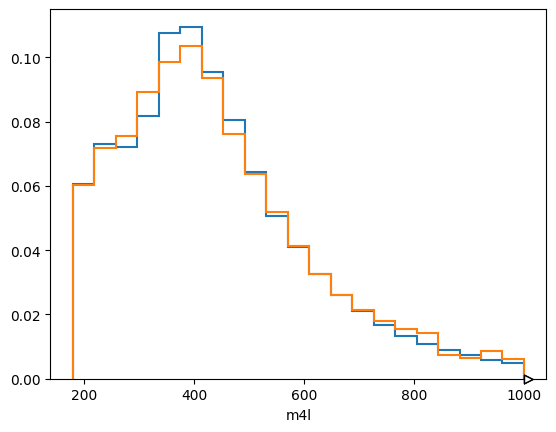

In [28]:
m4l_axis = hist.axis.Regular(21, 180, 1000, label = 'm4l')
h_m4l_num = hist.Hist(m4l_axis)
h_m4l_num_from_denom = hist.Hist(m4l_axis)

def calculate_m4l(kinematics):
    p_l1 = vector.array({'pt': kinematics['l1_pt'], 'eta': kinematics['l1_eta'], 'phi': kinematics['l1_phi'], 'energy': kinematics['l1_energy']})
    p_l2 = vector.array({'pt': kinematics['l2_pt'], 'eta': kinematics['l2_eta'], 'phi': kinematics['l2_phi'], 'energy': kinematics['l2_energy']})
    p_l3 = vector.array({'pt': kinematics['l3_pt'], 'eta': kinematics['l3_eta'], 'phi': kinematics['l3_phi'], 'energy': kinematics['l3_energy']})
    p_l4 = vector.array({'pt': kinematics['l4_pt'], 'eta': kinematics['l4_eta'], 'phi': kinematics['l4_phi'], 'energy': kinematics['l4_energy']})
    return (p_l1 + p_l2 + p_l3 + p_l4).mass


# IMPLEMENT ME
# NOTE: What should you do about the arbitrary normalization factor, N, from above?
w_num = torch.tensor(events_num_train.weights)
w_num_from_denom = torch.tensor(events_denom_train.weights * r_num_over_denom)
w_num /= torch.sum(w_num)
w_num_from_denom /= torch.sum(w_num_from_denom)

h_m4l_num.fill( calculate_m4l(events_num_train.kinematics), weight=w_num)
h_m4l_num_from_denom.fill( calculate_m4l(events_denom_train.kinematics), weight=w_num_from_denom)

h_m4l_num.plot()
h_m4l_num_from_denom.plot()

As performed in Chapter 1, you are encouraged to check in more detail via ratio plots. Qualitatively, are the histograms "compatible"?

## 2. Calibration curve

A more direct and systematic way to check is to obtain what is referred to as the _calibration_ curve of the DRE.

Task: perform the check for validation datasets as well --- are they also comparable? If not, you have an overfitting problem!

### 2.(a) Run the model over the numerator & denominator hypothesis datasets

We will make use of the pre-available `BalancedDataset` implementation (which was also used in the training) to consistently perform the $x$-scaling, event weight balancing, and $y = 0,1$ labeling of the numerator & denominator hypotheses.

In [ ]:
ds_train = BalancedDataset(events_num_train, events_denom_train, features=features_4l, scaler=scaler)
dl_test = torch.utils.data.DataLoader(torch.tensor(ds_train.X, dtype=torch.float32), batch_size=1024)
s_num_vs_denom = torch.cat(trainer.predict(model, dl_test).detach().numpy())

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/afs/ipp-garching.mpg.de/home/t/taepa/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

In [ ]:
targets_test = ds_test.s
weights_test = ds_test.w * len(ds_test)
print(predictions_test)

tensor([0.5050, 0.5037, 0.5030,  ..., 0.4785, 0.5036, 0.5044])


In [ ]:
s_bins = np.linspace(0.0, 1.0, 41)
s_centers = (s_bins[:-1] + s_bins[1:])/2
s_nbins = len(s_bins) -1
s_widths = (s_bins[1:] - s_bins[:-1])/2

s_bins = np.linspace(0.0, 1.0, 41)
s_centers = (s_bins[:-1] + s_bins[1:])/2
s_nbins = len(s_bins) -1
s_widths = (s_bins[1:] - s_bins[:-1])/2

In [ ]:
p = predictions_test
t = targets_test
w = weights_test

pred_binned = [p[(p >= s_bins[i]) & (p < s_bins[i+1])] for i in range(s_nbins)]
targets_binned = [t[(p >= s_bins[i]) & (p < s_bins[i+1])] for i in range(s_nbins)]
weights_binned = [w[(p >= s_bins[i]) & (p < s_bins[i+1])] for i in range(s_nbins)]

sig_per_bin = np.array([np.sum((targets_binned[i]==1.0) * weights_binned[i]) for i in range(s_nbins)])
bkg_per_bin = np.array([np.sum((targets_binned[i]==0.0) * weights_binned[i]) for i in range(s_nbins)])
s_true = sig_per_bin/(sig_per_bin+bkg_per_bin)

sig_err = np.sqrt(np.array([np.sum((targets_binned[i]==1.0) * weights_binned[i] * weights_binned[i]) for i in range(s_nbins)]))
bkg_err = np.sqrt(np.array([np.sum((targets_binned[i]==0.0) * weights_binned[i] * weights_binned[i]) for i in range(s_nbins)]))
s_err = np.sqrt(
    (sig_err * bkg_per_bin / (sig_per_bin + bkg_per_bin)**2)**2 +
    (bkg_err * sig_per_bin / (sig_per_bin + bkg_per_bin)**2)**2
)

/tmp/ipykernel_953008/3745675514.py:11: RuntimeWarning: invalid value encountered in divide
  s_true = sig_per_bin/(sig_per_bin+bkg_per_bin)
/tmp/ipykernel_953008/3745675514.py:16: RuntimeWarning: invalid value encountered in divide
  (sig_err * bkg_per_bin / (sig_per_bin + bkg_per_bin)**2)**2 +
/tmp/ipykernel_953008/3745675514.py:17: RuntimeWarning: invalid value encountered in divide
  (bkg_err * sig_per_bin / (sig_per_bin + bkg_per_bin)**2)**2


In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [4,1]}, figsize=(5,5), sharex=True)
ax1.set_aspect('equal', adjustable='box')

ax1.errorbar([0,1], [0,1], color='grey', linestyle='--', linewidth=lw, label='$\\mathrm{MC}$')
ax1.errorbar(s_centers, s_true, xerr=s_widths, yerr=s_err, color='cornflowerblue', linestyle='none', linewidth=lw,  label='$\\mathrm{NSBI}$')

ax1.set_ylim(0,1)
ax1.set_ylabel('$\\mathrm{MC\\ estimate}\\ \\frac{p_{q\\bar{q}}(x)}{ p_{q\\bar{q}}(x) + p_{gg}(x) }$', fontsize=15)

ax1.legend(frameon=False, fontsize=12)

ax2.errorbar([0,1], [0,0], color='grey', linestyle='--', linewidth=lw)
ax2.errorbar(s_centers, np.array(s_true)-np.array(s_centers), xerr=s_widths, yerr=s_err, color='cornflowerblue', linestyle='none', linewidth=lw)

ax2.set_xlim(0,1)
ax2.set_xlabel('$\\mathrm{NSBI\\ estimate}\\ \\hat{s}(x)$', fontsize=15)
ax2.set_ylabel('$\\mathrm{Residual}$', fontsize=15)
ax2.set_ylim(-0.075, 0.075)
ax2.yaxis.set_ticks([-0.05, 0.05])

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

# ax1.text(0.96 ,0.12, '$pp \\rightarrow ZZ \\rightarrow 4\\ell$', transform=ax1.transAxes, ha='right', va='bottom', fontsize=12)
ax1.text(0.96 ,0.12, '$pp \\rightarrow ZZ \\rightarrow 2\\ell 2\\nu$', transform=ax1.transAxes, ha='right', va='bottom', fontsize=12)
ax1.text(0.96 ,0.04, '$\\sqrt{s} = 14\\,\\mathrm{TeV}$', transform=ax1.transAxes, ha='right', va='bottom', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(hspace=0)

fig.canvas.draw()  # update positions
ax1_pos, ax2_pos = ax1.get_position(), ax2.get_position()
ax2.set_position([ax1_pos.x0, ax2_pos.y0, ax1_pos.width, ax2_pos.height]) # align 2nd x-axis with 1st

ax2.xaxis.set_tick_params(which='both', labeltop=False, top=True)

plt.savefig('carl_calibration.pdf', bbox_inches='tight')
plt.close()

In [ ]:
predictions_denominator_test = carl_model(torch.tensor(scaler.transform(events_d_test.kinematics[features].to_numpy()), dtype=torch.float32)).detach().numpy().ravel()
# predictions_denominator_val = carl_model(torch.tensor(scaler.transform(events_ninator_val.kinematics[features].to_numpy()), dtype=torch.float32)).detach().numpy().ravel()

In [ ]:
m4l_numerator = events_n_test.calculate(zz4l.FourLeptonSystem()).kinematics['4l_mass']
m4l_denominator = events_d_test.calculate(zz4l.FourLeptonSystem()).kinematics['4l_mass']
xobs_numerator = m4l_numerator
xobs_denominator = m4l_denominator
xbins = np.concatenate([np.arange(180,250,10), np.arange(250,500,50), np.arange(500,750,125), np.arange(750,1100,250)])
xmin, xmax = 180, 1000
xwidths = np.diff(xbins)
xcenters = xbins[:-1] + xwidths/2
xlabel = '$m_{ZZ}\\ \\mathrm{[GeV]}$'
y2_min, y2_max = 0.5, 3.5
y3_min, y3_max = 0.85, 1.15

# mtzz_numerator = events_n_test.calculate(zz2l2v.ZZ2L2V()).kinematics['zz_mt']
# mtzz_denominator = events_d_test.calculate(zz2l2v.ZZ2L2V()).kinematics['zz_mt']
# xobs_numerator = mtzz_numerator
# xobs_denominator = mtzz_denominator
# xbins = np.concatenate([np.arange(250,300,10), np.arange(300,400,25), np.arange(400,500,50), np.arange(500,1100,100)])
# xmin, xmax = 250, 1000
# xwidths = np.diff(xbins)
# xcenters = xbins[:-1] + xwidths/2
# xlabel = '$m_{\\mathrm T}^{ZZ}\\ \\mathrm{[GeV]}$'
# y2_min, y2_max = 0.75, 1.75
# y3_min, y3_max = 0.85, 1.15

In [ ]:
h_num_mc = hist.Hist(hist.axis.Variable(xbins), storage=hist.storage.Weight())
h_num_mc.fill(xobs_numerator, weight=events_n_test.probabilities)

h_denom = hist.Hist(hist.axis.Variable(xbins), storage=hist.storage.Weight())
h_denom.fill(xobs_denominator, weight=events_d_test.probabilities)

h_num_carl = hist.Hist(hist.axis.Variable(xbins), storage=hist.storage.Weight())
h_num_carl.fill(xobs_denominator, weight=events_d_test.probabilities * (predictions_denominator_test / (1 - predictions_denominator_test)))

fig, (ax1, ax2, ax3) = plt.subplots(3,1,gridspec_kw={'height_ratios': [2, 1, 1]},figsize=(5,6), layout='constrained', sharex=True)

ax1.stairs(h_num_carl.values()/xwidths, h_num_carl.axes[0].edges, color='cornflowerblue', linewidth=lw, label='$q\\bar{q} \\to ZZ\\ (\\mathrm{NSBI})$')
ax1.stairs(h_num_mc.values()/xwidths, h_num_mc.axes[0].edges, color='blue', linestyle='--', linewidth=lw, label='$q\\bar{q} \\to ZZ\\ (\\mathrm{MC})$')
ax1.stairs(h_denom.values()/xwidths, h_denom.axes[0].edges, color='black', linestyle='--', linewidth=lw, label='$gg(\\to h^{\\ast}) \\to ZZ$')

ax2.stairs(h_num_carl.values()/h_denom.values(), h_num_mc.axes[0].edges, color='cornflowerblue', linewidth=lw)
ax2.stairs(h_num_mc.values()/h_denom.values(), h_num_mc.axes[0].edges, color='blue', linestyle='--', linewidth=lw)
ax2.stairs(h_denom.values()/h_denom.values(), h_denom.axes[0].edges, color='black', linestyle='--', linewidth=lw)

ax3.stairs(h_num_mc.values()/h_num_mc.values(), xbins, color='blue', linestyle='--', linewidth=lw)
ax3.errorbar(xcenters, h_num_carl.values()/h_num_mc.values(), yerr=np.sqrt(h_num_carl.variances())/h_num_carl.values(), xerr=xwidths/2, fmt='none', color='cornflowerblue', linewidth=lw)

ax1.legend(frameon=False, fontsize=12)

ax1.set_yscale('log')
ax2.set_ylim(y2_min, y2_max)
ax3.set_ylim(y3_min, y3_max)

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax3.tick_params(labelsize=12)

ax1.set_ylabel('$\\mathrm{Density\\ of\\ events\\ [1/GeV]}$', fontsize=15, loc='top')
ax2.set_ylabel('$p_{q\\bar{q}}/p_{gg}$', fontsize=15)
ax3.set_ylabel('$\\mathrm{NSBI}/\\mathrm{MC}$', fontsize=12)

ax3.set_xlabel(xlabel, fontsize=12)
ax3.set_xlim(xmin, xmax)

plt.tight_layout()
plt.subplots_adjust(hspace=0)

plt.savefig('carl_reweight.pdf', bbox_inches='tight')

/tmp/ipykernel_953008/2950299888.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
